# Task 1 ：复现实验，添加噪音验证二分类识别方法的抗噪能力
实验结果：https://huggingface.co/datasets/JimXie/IIoTset/resolve/main/performance.tar.gz

分析文章的baseline，发现该方法无法在真实场景中使用：
1. 选取的数据集中，有异常数据
2. 选取的特征中，有无效特征
3. 通过特征图筛选，可以筛选出3～4个特征，使用筛选出来的特征，可达到与全部特征相近的结果
4. 选取的特征，为不稳定特征，无法在真实场景中使用

In [1]:
import os,sys
sys.path.append("./share")
sys.path.append("./common")
sys.path.append("./ml")
from Config import g_data_root
import pandas as pd
import numpy as np
import warnings,logging,re
from SHVisualize import CSHVisualize
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from SHModelClassify import CSHModelClassify
from SHSample import CSHSample
from SHDataProcess import CSHDataProcess
from SHDataEDA import CSHDataDistribution,CSHDataTest
from SHFeatureSelect import CSHFeature
from IoTNoise import CIoTNoise
import seaborn as sns
import h2o
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB
tqdm.pandas()
import warnings
warnings.simplefilter(action='ignore')
h2o.init(nthreads = -1, verbose=False)
np.random.seed(42)

In [2]:
def is_valid_ip(ip_str):
    ip_pattern = re.compile(r'^((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$')
    if ip_pattern.match(ip_str):
        octets = ip_str.split('.')
        for octet in octets:
            if int(octet) > 255:
                return False
        return True
    else:
        return False

def is_valid_time(time_str):
    tmp = time_str.strip()
    tmp = tmp[:-3]
    try:
        datetime.strptime(tmp, '%Y %H:%M:%S.%f')
        return True
    except ValueError:
        return False

# 定义公共函数

In [3]:
df = pd.read_csv("%s/raw/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv"%g_data_root,low_memory=False)

# 查看样本格式

In [4]:
df.keys().tolist()

['frame.time',
 'ip.src_host',
 'ip.dst_host',
 'arp.dst.proto_ipv4',
 'arp.opcode',
 'arp.hw.size',
 'arp.src.proto_ipv4',
 'icmp.checksum',
 'icmp.seq_le',
 'icmp.transmit_timestamp',
 'icmp.unused',
 'http.file_data',
 'http.content_length',
 'http.request.uri.query',
 'http.request.method',
 'http.referer',
 'http.request.full_uri',
 'http.request.version',
 'http.response',
 'http.tls_port',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'tcp.connection.fin',
 'tcp.connection.rst',
 'tcp.connection.syn',
 'tcp.connection.synack',
 'tcp.dstport',
 'tcp.flags',
 'tcp.flags.ack',
 'tcp.len',
 'tcp.options',
 'tcp.payload',
 'tcp.seq',
 'tcp.srcport',
 'udp.port',
 'udp.stream',
 'udp.time_delta',
 'dns.qry.name',
 'dns.qry.name.len',
 'dns.qry.qu',
 'dns.qry.type',
 'dns.retransmission',
 'dns.retransmit_request',
 'dns.retransmit_request_in',
 'mqtt.conack.flags',
 'mqtt.conflag.cleansess',
 'mqtt.conflags',
 'mqtt.hdrflags',
 'mqtt.len',
 'mqtt.msg_decoded_as',
 'mqtt.msg',
 'mqtt.m

# 过滤掉异常数据
1. 时间格式错误
2. ip地址错误

In [5]:
def pre_process(x):
    ret = "ok"
    if not is_valid_time(x['frame.time']):
        ret = "frame.time"
    elif not is_valid_ip(x['ip.src_host']) and not is_valid_ip(x['arp.src.proto_ipv4']):
        ret = "src_host"
    elif not is_valid_ip(x['ip.dst_host']) and not is_valid_ip(x['arp.dst.proto_ipv4']):
        ret = "dst_host"
    return ret
    
df['flag'] = df.progress_apply(pre_process,axis=1)
df = df[df['flag'] == "ok"]

del df['frame.time']
del df['ip.src_host']
del df['ip.dst_host']
del df['arp.src.proto_ipv4']
del df['arp.dst.proto_ipv4']
del df['tcp.srcport']
del df['tcp.dstport']
del df['udp.port']
del df['tcp.payload']
del df['http.tls_port']
del df['http.file_data']
del df['icmp.transmit_timestamp']
del df['http.request.uri.query']
del df['http.referer']
del df['http.request.full_uri']
del df['http.request.version']
del df['tcp.options']
del df['dns.qry.name.len']
del df['mqtt.msg']

one_hot_encoded = pd.get_dummies(df['http.request.method'],prefix='http.request.method')
df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.conack.flags'],prefix='mqtt.conack.flags')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.protoname'],prefix='mqtt.protoname')
#df = pd.concat([df, one_hot_encoded], axis=1)
#one_hot_encoded = pd.get_dummies(df['mqtt.topic'],prefix='mqtt.topic')
#df = pd.concat([df, one_hot_encoded], axis=1)

del df['http.request.method']
del df['mqtt.conack.flags']
del df['mqtt.protoname']
del df['mqtt.topic']
df['Attack_type']=df['Attack_type'].astype(dtype='category')
df['Attack_code']=df['Attack_type'].cat.codes

  0%|          | 0/157800 [00:00<?, ?it/s]

# 发现异常特征
1. mqtt.conack.flags
2. mqtt.protoname
3. mqtt.topic

In [6]:
#mqtt.conack.flags_0',
#'mqtt.conack.flags_0.0',
#'mqtt.conack.flags_0x00000000'
#df_tmp = df[['http.request.method','mqtt.protoname','mqtt.topic','mqtt.conack.flags','Attack_label']]
#df_tmp=df_tmp[df_tmp['Attack_label'] == 1]
#df_tmp['mqtt.topic'].unique()

# 选取base的特征
1. 去掉冗余字段
2. 设置特征字段和标签字段
3. 去掉只有唯一值的特征

In [7]:
df_base = df.copy(deep=True)
del df_base['Attack_type']
del df_base['flag']
del df_base['Attack_code']

#for col in df_base.columns.tolist():
#    if col in ['tcp.ack','tcp.flags','tcp.connection.rst','http.request.method_0.0','tcp.ack_raw','http.request.method_0']:
#        del df_base[col]
        
for key in df_base.columns:
    if df_base[key].nunique() <= 1:
        del df_base[key]
        
#for key,type in zip(df_base.dtypes.index,df_base.dtypes):
#    key = str(key)
#    if type == 'bool':
#        df_base[key] = df_base[key].astype(int)

col_y = "Attack_label"
col_x = []
for col in df_base.columns.tolist():
    if not col == col_y:
        col_x.append(col)

# 进行SMOTE采样

In [8]:
df_tmp = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 

# 对特征字段进行标准化处理

In [9]:
df_data, scale_columns = CSHDataProcess.get_scale(df_tmp,y_column=col_y)
df_raw = df_data.copy(deep = True)

# 查看信息图

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
infogram Model Build progress: |█████████████████████████████████████████████████| (done) 100%


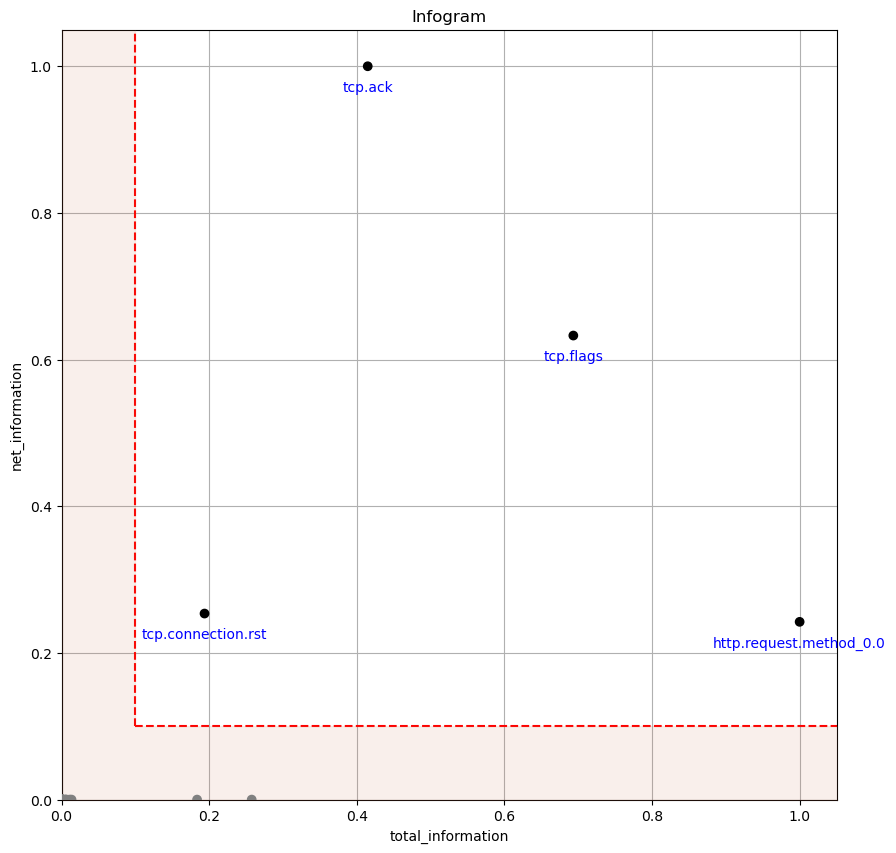

In [10]:
Fea = CSHFeature()
Fea.load(df_data,x_columns = col_x, y_column=col_y,is_regression = False)
ig = Fea.get_inform_graph("AUTO")
ig.plot()

# 使用原始特征

## 添加噪音的特征

In [11]:
dtypes_dict = df_raw.dtypes.to_dict()
noised_columns = []
for f,t in dtypes_dict.items():
    if t in ['int','int64','float','bool']:
        if f != col_y:
            noised_columns.append(f)
print("Total noised columns",len(noised_columns),len(col_x))

Total noised columns 37 37


## 创建数据集

In [12]:
def add_noise(df_input,ratio=0.1):
    df_data = df_input.copy(deep = True)
    for feature in df_data.keys().tolist():
        if feature in ['Attack_label']:
            continue
        dtypes_dict = df_input.dtypes.to_dict()
        type = dtypes_dict[feature]
        df_data[feature] = CIoTNoise.add_noise(feature,type,df_data,ratio)
    return df_data

def train_test(df_train,df_test):
    model = CSHModelClassify()
    model.train(df_train,x_columns=col_x,y_column=col_y,train_ratio = 0)
    df_importance = model.importance()
    df_result = pd.DataFrame()
    for ratio in tqdm([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]):
        df_test_noised = add_noise(df_test,ratio=ratio)
        df_verify_noised = model.evaluate(df_test_noised,x_columns=col_x,y_column=col_y)
        df_verify_noised['ratio'] = ratio
        df_result = pd.concat([df_result,df_verify_noised],ignore_index=True)
    df_result = df_result.reset_index(drop=True)
    return df_importance,df_result

## 使用所有特征训练模型，验证抗噪能力

In [ ]:
df_data = df_raw.copy(deep = True)
df_train,df_test = CSHSample.split_dataset(df_data)
df_importance,df_verify = train_test(df_train,df_test)
df_verify.to_csv("./IIoTSet/result/二分类-原始46个特征-标准化前.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
dt Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
psvm Model Build progress: |█████████████████████████████████

## 使用Normal转换后特征训练模型，验证抗噪能力

In [ ]:
df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 
df_tmp = df_data.copy(deep = True)
scale_colums = []
for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
    if not type in ["bool","object","category"] and not key in [col_y]:
        scale_colums.append(key)
    if df_tmp[key].dtype =='bool':
        df_tmp[key] = df_tmp[key].astype(int)
for key in scale_colums:
    df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
    df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    
df_train,df_test = CSHSample.split_dataset(df_tmp)
df_importance,df_verify = train_test(df_train,df_test)
df_verify.to_csv("./IIoTSet/result/二分类-原始46个特征.csv")

## 只使用4个特征训练模型，验证抗噪能力

In [ ]:
df_data = CSHSample.resample_smote(df_base,x_columns=col_x,y_column=col_y) 
df_tmp = df_data.copy(deep = True)
scale_colums = []
for key,type in zip(df_tmp.keys(),df_tmp.dtypes):
    if not type in ["bool","object","category"] and not key in [col_y]:
        scale_colums.append(key)
    if df_tmp[key].dtype =='bool':
        df_tmp[key] = df_tmp[key].astype(int)
for key in scale_colums:
    df_tmp[key] = (df_tmp[key]-df_tmp[key].min())/(df_tmp[key].max()-df_tmp[key].min()) + 1
    df_tmp[key],l = CSHDataProcess.normal_transform(df_tmp[key])
    
col_x = ['tcp.ack','tcp.flags','tcp.connection.rst','http.request.method_0.0']
col_y = 'Attack_label'
df_tmp = df_data[col_x]
df_tmp[col_y] = df_data[col_y]
df_train,df_test = CSHSample.split_dataset(df_tmp)
df_importance,df_verify = train_test(df_train,df_test)
df_verify.to_csv("./IIoTSet/result/二分类-原始4个特征.csv")

# 显示实验结果

In [2]:
def show_result(df_result):
    for model in df_result['model'].unique():
        df_tmp = df_result[df_result['model']==model]
        del df_tmp['model']
        df_tmp = df_tmp.groupby('ratio').mean()
        df_tmp = df_tmp.sort_values(by='ratio').reset_index()
        df_long = pd.melt(df_tmp, 
                          id_vars=['ratio'], 
                          value_vars=['recall', 'precision','accuracy','f1_score'], 
                          var_name='metric', value_name='value')
        sns.barplot(x='ratio', y='value',hue='metric',orient='v',ci=None,data=df_long)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.110), ncol=4)
        plt.xlabel('Noise ratio', fontsize=10)
        plt.ylabel('Metric value', fontsize=10)
        plt.title('Performance of %s'%model, fontsize=12)
        plt.show()

In [ ]:
df_result = pd.read_csv("./IIoTSet/result/二分类-原始46个特征-标准化前.csv")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio']]
show_result(df_result)

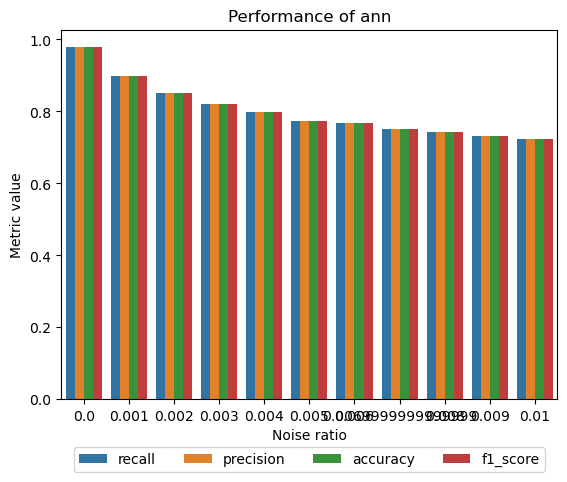

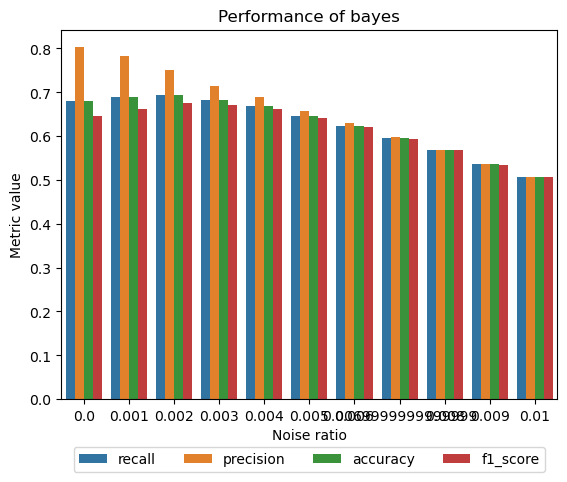

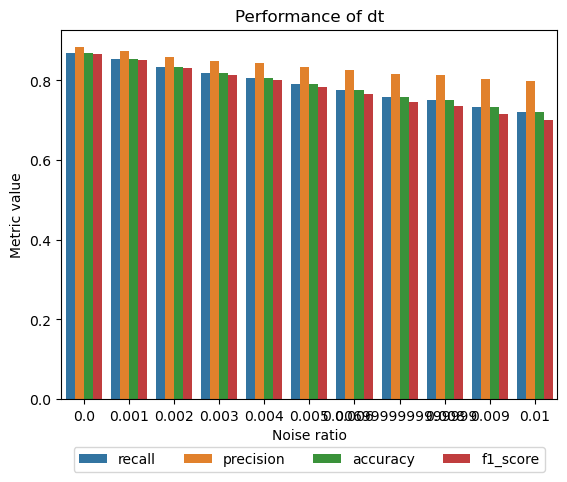

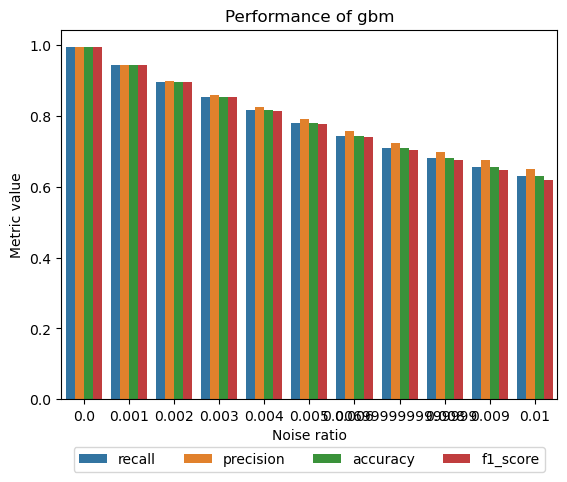

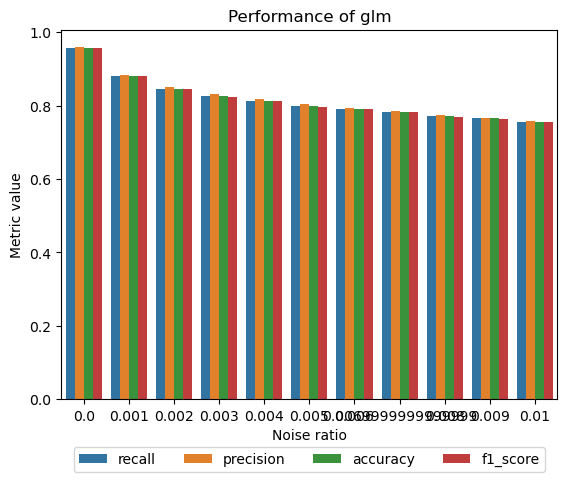

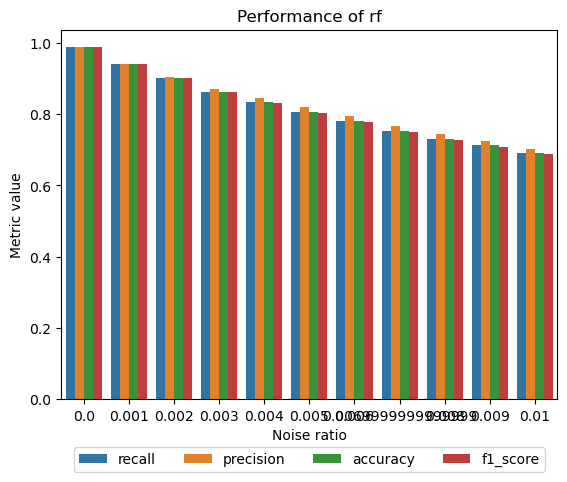

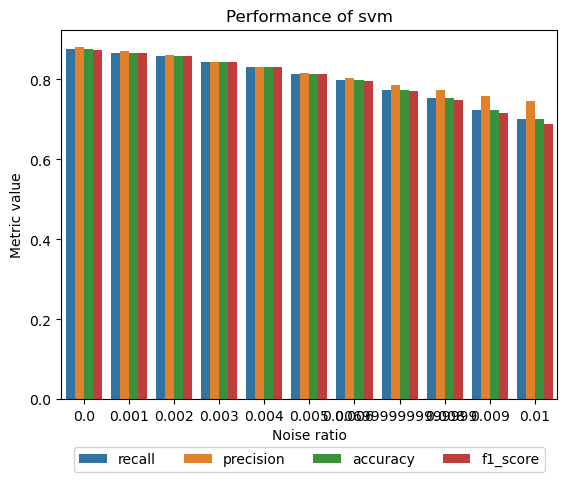

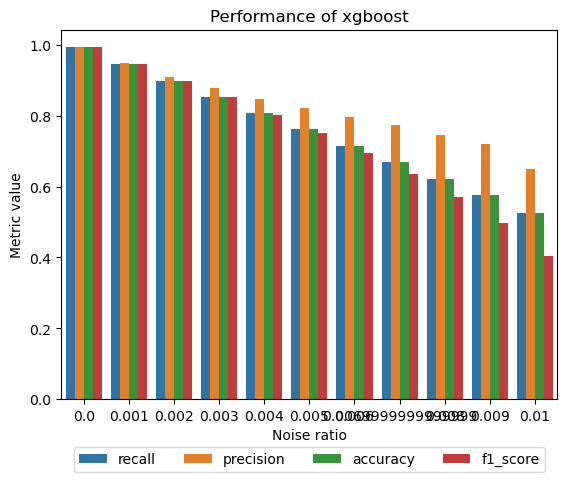

In [7]:
df_result = pd.read_csv("./IIoTSet/result/二分类-原始46个特征.csv")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio']]
show_result(df_result)

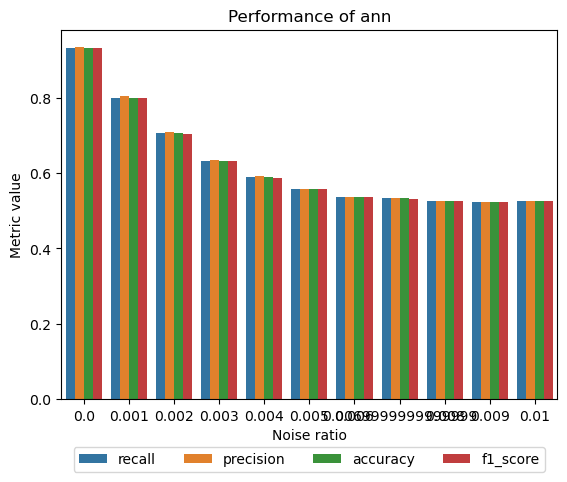

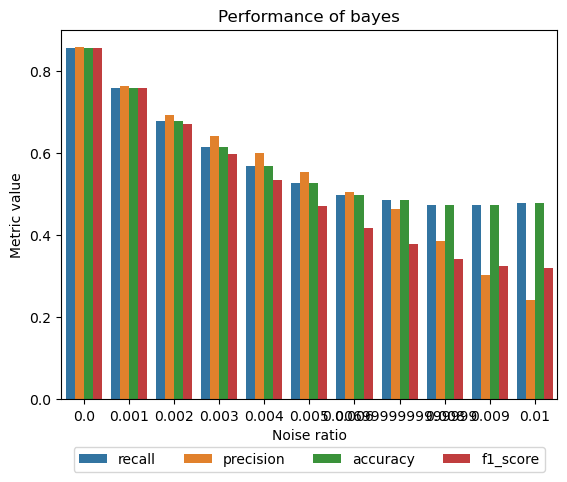

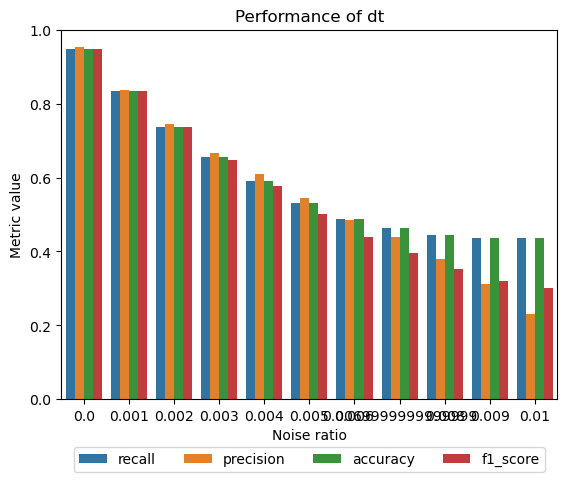

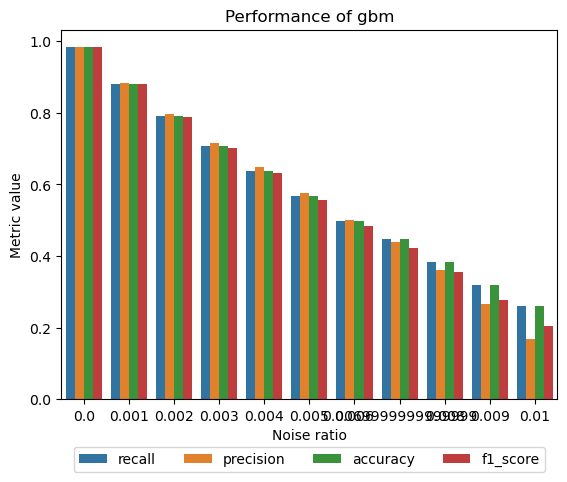

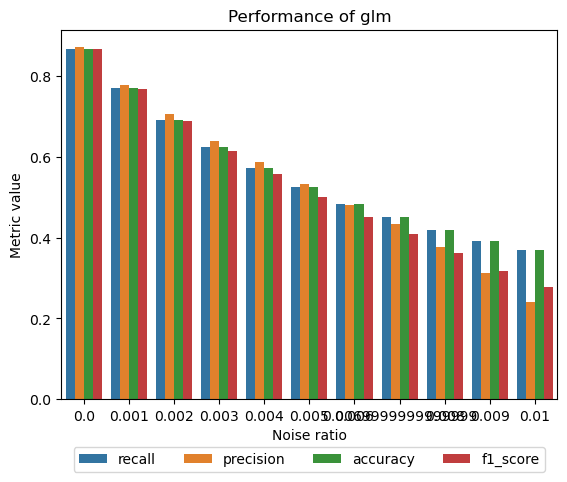

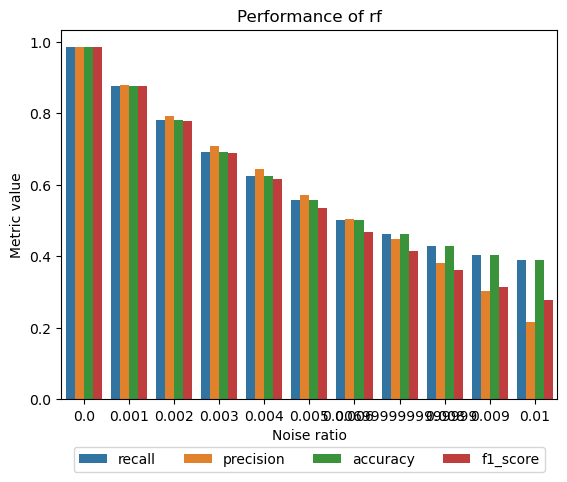

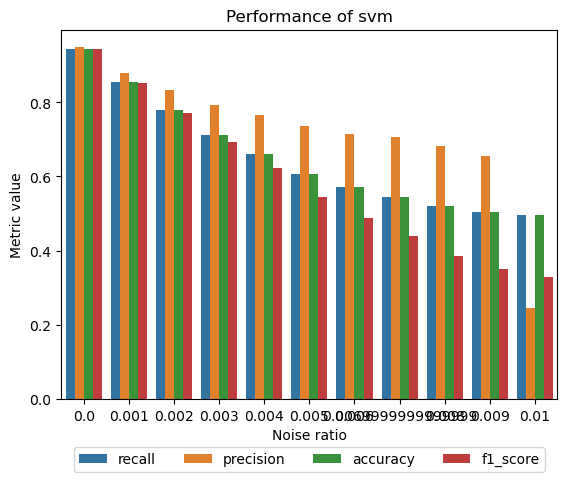

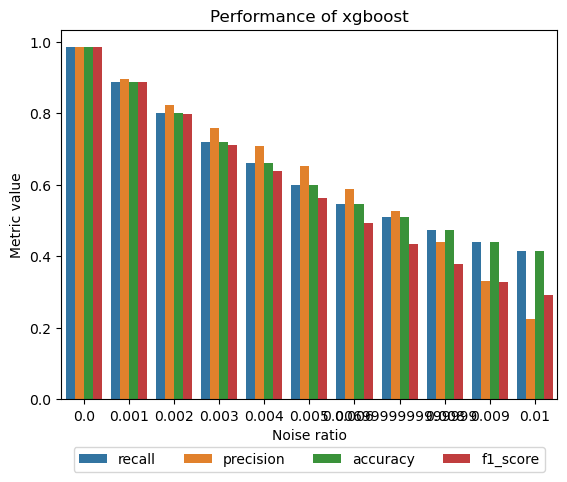

In [9]:
df_result = pd.read_csv("./IIoTSet/result/二分类-原始4个特征.csv")
df_result = df_result[['model','recall','accuracy','precision','auc','f1_score','ratio']]
show_result(df_result)